# L96 Adaptive Integrator

Here we write code for a two layer adaptive L96 integrator. Done both tangent and normal two layer L96.

Double check everything, but seems to be working :)

In [13]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
import xarray as xr
from scipy.stats import gaussian_kde
import scipy.integrate

In [3]:
class Integrator:

    """Integrates the 2 layer L96 ODEs."""
    def __init__(self, K=36, J=10, h=1, Ff=6, Fs=10, b=10, c=10,
                 X_init=None, Y_init=None, dx_init=None, dy_init=None):

        # Model parameters
        self.K, self.J, self.h, self.Ff, self.Fs, self.b, self.c= K, J, h, Ff, Fs, b, c
        self.size = self.K + (self.J * self.K) # Number of variables
        
        self.time = 0 

        # Non-linear Variables
        self.X = np.random.rand(self.K) if X_init is None else X_init.copy() # Random IC if none given
        self.Y = np.random.rand(self.K * self.J) if Y_init is None else Y_init.copy()  # ALL the y's


    def _rhs_X_dt(self, X, Y):
        """Compute the right hand side of the X-ODE."""

        dXdt = (
                np.roll(X, 1) * (np.roll(X, -1) - np.roll(X, 2)) -
                X + self.Fs - ((self.h * self.c)/self.b) * Y.reshape(self.K, self.J).sum(1)
        )
        return dXdt

    def _rhs_Y_dt(self, X, Y):
        """Compute the right hand side of the Y-ODE."""
        dYdt = self.c * (
                          self.b * np.roll(Y, -1) * ( np.roll(Y, 1) - np.roll(Y, -2) )
                       - Y + self.Ff/self.b + (self.h/self.b) * np.repeat(X, self.J) # repeat so x's match y's
               )
        return dYdt


    def _rhs_dt(self, t, state):
        X, Y = state[:self.K], state[self.K:]
        return [*self._rhs_X_dt(X, Y), *self._rhs_Y_dt(X, Y)]
    
    def integrate(self, how_long):
        """time: how long we integrate for in adimensional time."""
        
        # Where We are
        t = self.time
        IC = self.state
        
        # Integration, uses RK45 with adaptive stepping. THIS IS THE HEART.
        solver_return = scipy.integrate.solve_ivp(self._rhs_dt, (t, t + how_long), IC, dense_output = True)
        
        # Updating variables
        new_state = solver_return.y[:,-1]
        self.X = new_state[:self.K]
        self.Y = new_state[self.K: self.size] 
        
        self.time = t + how_long

    def set_state(self, x):
        """x is [X, Y]. tangent_x is [dx, dy]"""
        self.X = x[:self.K]
        self.Y = x[self.K:] 
        
    @property
    def state(self):
        """Where we are in phase space."""
        return np.concatenate([self.X, self.Y])

    @property
    def time(self):
        """a-dimensional time"""
        return self.__time
    
    @time.setter   
    def time(self, when):
        self.__time = when

    @property
    def parameter_dict(self):
        param = {
        'h': self.h, # L96
        'Fs': self.Fs,
        'Ff': self.Ff,
        'c': self.c,
        'J': self.J,
        'K': self.K,
        'Number of variables': self.size,
        'b': self.b,
        }
        return param

In [4]:
class TrajectoryObserver():
    """Observes the trajectory of L96 ODE integrator. Dumps to netcdf."""

    def __init__(self, integrator, name='L96 Trajectory'):
        """param, integrator: integrator being observed."""

        # Needed knowledge of the integrator
        self._K = integrator.K
        self._J = integrator.J
        self._parameters = integrator.parameter_dict

        # Trajectory Observation logs
        self.time_obs = [] # Times we've made observations
        self.x_obs = []
        self.y_obs = []

    def look(self, integrator):
        """Observes trajectory of L96 trajectory"""

        # Note the time
        self.time_obs.append(integrator.time)

        # Making Observations
        self.x_obs.append(integrator.X.copy())
        self.y_obs.append(integrator.Y.copy()) 
       
    @property
    def observations(self):
        """cupboard: Directory where to write netcdf."""
        if (len(self.x_obs) == 0):
            print('I have no observations! :(')
            return

        dic = {}
        _time = self.time_obs
        dic['X'] = xr.DataArray(self.x_obs, dims=['time', 'K'], name='X',
                                coords = {'time': _time,'K': np.arange(1, 1 + self._K)})
        dic['Y'] = xr.DataArray(self.y_obs, dims=['time', 'KJ'], name='Y',
                                coords = {'time': _time, 'KJ': np.arange(1, 1 + self._K * self._J)})
        return xr.Dataset(dic, attrs= self._parameters)

    def wipe(self):
        """Erases observations"""
        self.time_obs = []
        self.x_obs = []
        self.y_obs = []
        
    def dump(self, cupboard, name=None):
        """ Saves observations to netcdf and wipes.
        cupboard: Directory where to write netcdf.
        name: file name"""

        if (len(self.x_obs) == 0):
            print('I have no observations! :(')
            return

        if name == None:
            name=self.name

        save = cupboard + f'/{name}' + f'{self.dump_count + 1}.nc'
        self.observations.to_netcdf(save)
        print(f'Observations written to {save}. Erasing personal log.\n')
        self.wipe()
        self.dump_count +=1

In [ ]:
class TangentIntegrator:

    """Integrates the L96 ODEs and it's tangent dynamics simultaneously."""
    def __init__(self, K=36, J=10, h=1, Ff=6, Fs=10, b=10, c=10,
                 X_init=None, Y_init=None, dx_init=None, dy_init=None):

        # Model parameters
        self.K, self.J, self.h, self.Ff, self.Fs, self.b, self.c= K, J, h, Ff, Fs, b, c
        self.size = self.K + (self.J * self.K) # Number of variables
        
        self.time = 0 

        # Non-linear Variables
        self.X = np.random.rand(self.K) if X_init is None else X_init.copy() # Random IC if none given
        self.Y = np.random.rand(self.K * self.J) if Y_init is None else Y_init.copy()  # ALL the y's

        # TLE Variables
        self.dx = np.array([i/10000 for i in np.random.rand(self.K)]) if dx_init is None else dx_init.copy()
        self.dy = np.array([i/10000 for i in np.random.rand(self.K * self.J)]) if dy_init is None else dy_init.copy()

    def _rhs_X_dt(self, X, Y):
        """Compute the right hand side of the X-ODE."""

        dXdt = (
                np.roll(X, 1) * (np.roll(X, -1) - np.roll(X, 2)) -
                X + self.Fs - ((self.h * self.c)/self.b) * Y.reshape(self.K, self.J).sum(1)
        )
        return dXdt

    def _rhs_Y_dt(self, X, Y):
        """Compute the right hand side of the Y-ODE."""
        dYdt = self.c * (
                          self.b * np.roll(Y, -1) * ( np.roll(Y, 1) - np.roll(Y, -2) )
                       - Y + self.Ff/self.b + (self.h/self.b) * np.repeat(X, self.J) # repeat so x's match y's
               )
        return dYdt

    def _rhs_dx_dt(self, X, dx, dy):
        """Compute rhs of the dx-ODE"""
        ddxdt = (
                    np.roll(dx, 1) * ( np.roll(X, -1) - np.roll(X, 2) )
                    + np.roll(X, 1) * ( np.roll(dx, -1) - np.roll(dx, 2) ) - dx
                   - ((self.h * self.c)/self.b) * dy.reshape(self.K, self.J).sum(1)
        )
        return ddxdt

    def _rhs_dy_dt(self, Y, dx, dy):
        """Compute rhs of the dy-ODE"""
        ddydt = self.c * self.b  * (
                            np.roll(dy, -1) * (np.roll(Y, 1) - np.roll(Y, -2) )
                          + np.roll(Y, -1) * (np.roll(dy, 1) - np.roll(dy, -2) ))
        - self.c * dy + ((self.h * self.c)/self.b) * np.repeat(dx, self.J)
        return ddydt

    def _rhs_dt(self, t, state):
        X, Y = state[:self.K], state[self.K: self.size]
        dx, dy = state[self.size: self.size + self.K], state[self.size + self.K: ]
        return [*self._rhs_X_dt(X, Y), *self._rhs_Y_dt(X, Y), *self._rhs_dx_dt(X, dx, dy), *self._rhs_dy_dt(Y, dx, dy)]
    
    def integrate(self, how_long):
        """time: how long we integrate for in adimensional time."""
        
        # Where We are
        t = self.time
        IC = np.hstack((self.state, self.tangent_state))
        
        # Integration, uses RK45 with adaptive stepping. THIS IS THE HEART.
        solver_return = scipy.integrate.solve_ivp(self._rhs_dt, (t, t + how_long), IC, dense_output = True)
        
        # Updating variables
        new_state = solver_return.y[:,-1]
        self.X = new_state[:self.K]
        self.Y = new_state[self.K: self.size] 
        self.dx = new_state[self.size: self.size + self.K]
        self.dy = new_state[self.size + self.K: ]
        
        self.time = t + how_long

    def set_state(self, x, tangent_x):
        """x is [X, Y]. tangent_x is [dx, dy]"""
        self.X = x[:self.K]
        self.Y = x[self.K:] 
        self.dx = tangent_x[: self.K]
        self.dy = tangent_x[self.K: ]
        
   
    @property
    def state(self):
        """Where we are in phase space."""
        return np.concatenate([self.X, self.Y])

    @property
    def tangent_state(self):
        """Where we are in tangent space"""
        return np.concatenate([self.dx, self.dy])

    @property
    def time(self):
        """a-dimensional time"""
        return self.__time
    
    @time.setter   
    def time(self, when):
        self.__time = when

    @property
    def parameter_dict(self):
        param = {
        'h': self.h, # L96
        'Fs': self.Fs,
        'Ff': self.Ff,
        'c': self.c,
        'J': self.J,
        'K': self.K,
        'Number of variables': self.size,
        'b': self.b,
        }
        return param

In [ ]:
%%timeit

test.integrate(0.1)

In [5]:
from l96adaptive import make_observations

In [7]:
runner = Integrator()
looker = TrajectoryObserver(runner)

make_observations(runner, looker, 10000, 0.01)

In [9]:
data = looker.observations

In [10]:
# Plotting PDF of X in a single sector

def kde_pdf(samples, title, xlabel='', save=None):
    fig, ax = plt.subplots()
    x_d = np.linspace(samples.min() - 1, samples.max() + 1, 1000) # Grid we evaluate PDF on
    kde = gaussian_kde(samples) # KDE. Using Gaussian ker
    pdf = kde.evaluate(x_d)
    ax.plot(x_d, pdf)
    ax.set_ylabel('$\\rho$')
    ax.set_xlabel(xlabel)
    #ax.plot(samples, np.full_like(samples, -0.01), 'k*', label='samples')
    #ax.legend()
    ax.grid()
    ax.set_title(title)
    if (save!=None):
        print(f'Saving plot at {save}')
        fig.savefig(save, dpi=1200)
    fig.show()

In [14]:
indices = random.choice(data.X.K.values, size = (10), replace = False)
Xs = [data.X.sel(K = i) for i in indices]

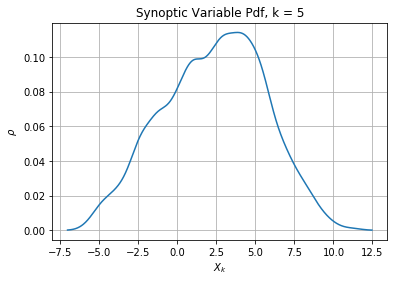

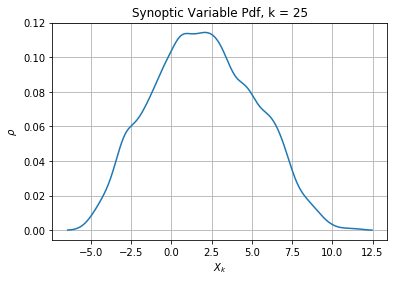

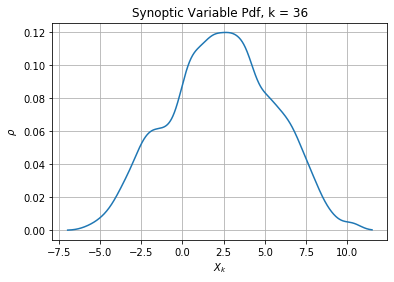

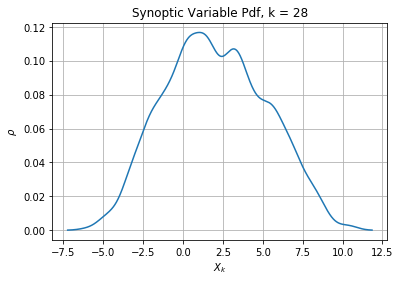

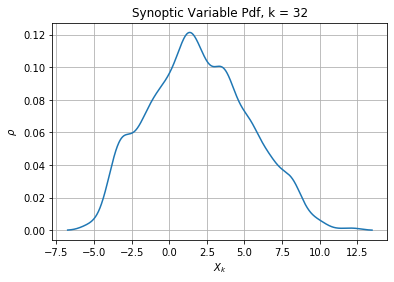

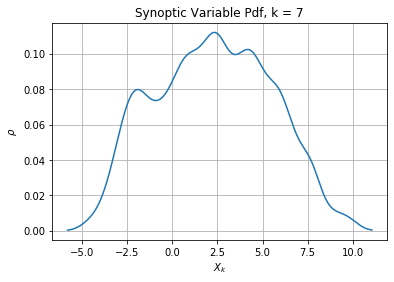

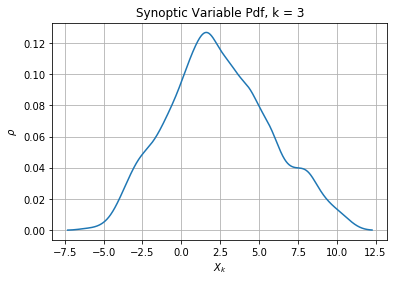

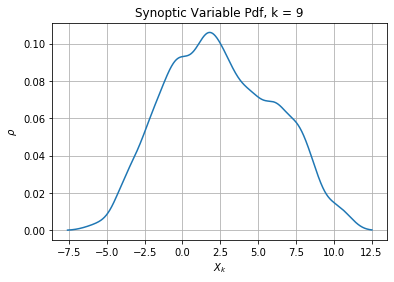

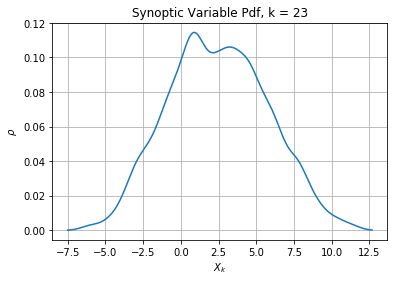

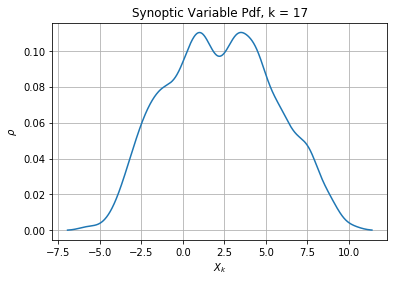

In [15]:
for X in Xs:
    index = X.K.item()
    title = f'Synoptic Variable Pdf, k = {index}'
    kde_pdf(X.values, title, xlabel = '$X_k$')

In [16]:
### Plotting Convective Scale Pdfs

In [17]:
indices = random.choice(data.Y.KJ.values, size = (10), replace = False)
Ys = [data.Y.sel(KJ = i) for i in indices]

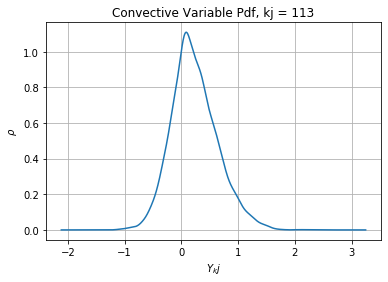

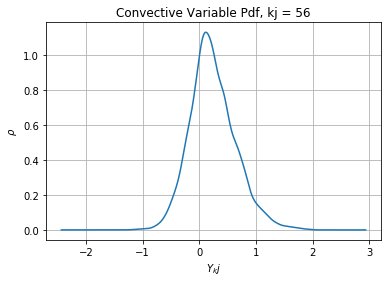

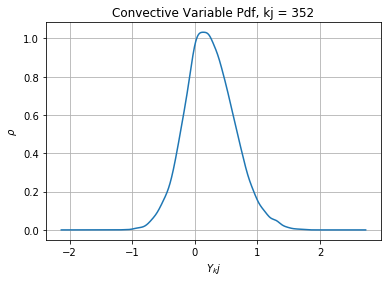

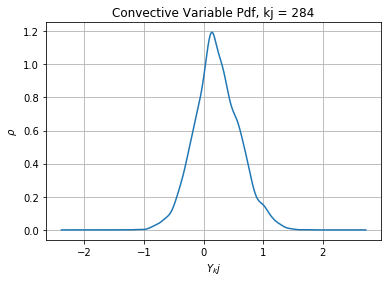

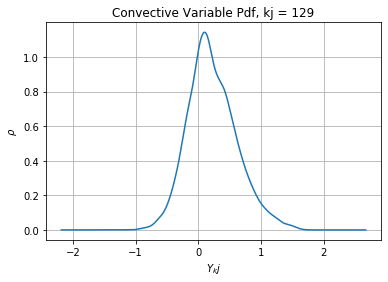

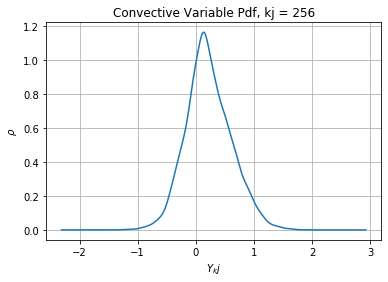

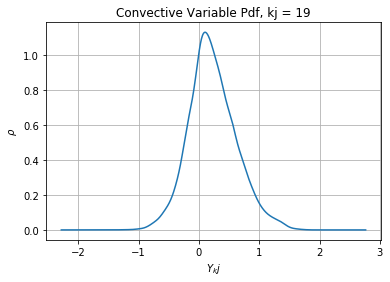

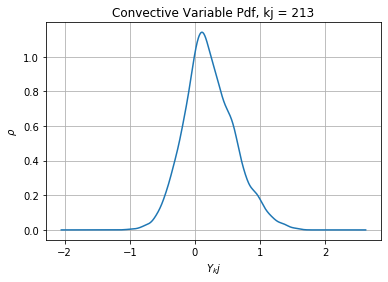

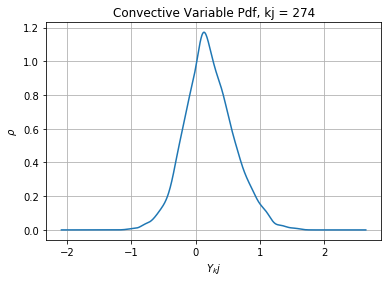

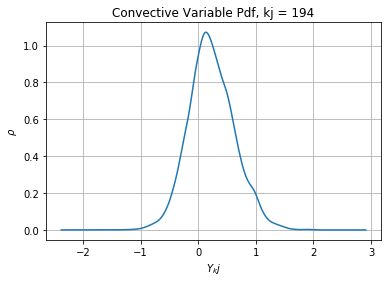

In [18]:
for Y in Ys:
    index = Y.KJ.item()
    title = f'Convective Variable Pdf, kj = {index}'
    kde_pdf(Y.values, title, xlabel = '$Y_kj$')